In [1]:
#libraries
library(GO.db)
library(topGO)
library(org.Sc.sgd.db)
library(GOSemSim)
library(gridExtra)

Loading required package: AnnotationDbi
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colnames, do.call,
    duplicated, eval, evalq, Filter, Find, get, grep, grepl, intersect,
    is.unsorted, lapply, lengths, Map, mapply, match, mget, order,
    paste, pmax, pmax.int, pmin, pmin.int, Position, rank, rbind,
    Reduce, rownames, sapply, setdiff, sort, table, tapply, union,
    unique, unsplit, which, which.max, which.min

Loading required package: Biobase
Welcome to Bioconductor

 

In [2]:
file <- "yeast_uetz"

ont <- "BP"
p <- 0.5
init <- 1

db <- org.Sc.sgd.db
mapping <- "org.Sc.sgd.db"
ID <- "ENSEMBL"

##load all community gene lists
setwd(sprintf("/home/david/Documents/ghsom/%s_hierarchy_communities_%s_%s", file, p, init))

scGO <- godata(OrgDb = mapping, keytype = ID, ont = ont)

[1] "preparing gene to GO mapping data..."
[1] "preparing IC data..."


In [3]:
generateMap <- function(filename){
    map <- as.matrix(read.csv(filename, sep=",", header = F))
    communities <- map[,1]
    map <- map[,2:ncol(map)]
    rownames(map) <- communities
    colnames(map) <- communities
    return (map)
}

In [4]:
#background gene list
backgroundFilename <- "all_genes.txt"
allGenes <- scan(backgroundFilename, character())

#shortest path files
shortestPathFiles  <- list.files(pattern="*shortest_path*")

#shortest paths list
shortestPaths <- sapply(shortestPathFiles, generateMap)
names(shortestPaths) <- sapply(names(shortestPaths), function(name) strsplit(name, "_")[[1]][[1]])

#communitiy assignemtns
assignments <- as.matrix(read.csv("assignment_matrix.csv", sep=",", header=F))
rownames(assignments) <- allGenes
colnames <- sapply(1:ncol(assignments), function(i) as.character(i-1))
colnames(assignments) <- colnames

In [5]:
getDepth <- function(com) {
    return(which(apply(assignments, 2, function(i) any(i == com))))
}

getGenes <- function(com){
    return(names(which(assignments[,getDepth(com)] == com)))
}

getSubCommunities <- function(com){
    return(try(as.character(unique(assignments[getGenes(com), getDepth(com) + 1]))))
}

getSuperCommunity <- function(com){
    return(try(as.character(unique(assignments[getGenes(com), getDepth(com) - 1]))))
}

getShortestPath <- function(com){
    return (try(shortestPaths[[com]]))
}

In [6]:
communitySimilarity <- function(community) {
    geneSims <- mgeneSim(genes = getGenes(as.character(community)), 
                         semData = scGO, measure = "Wang", combine = "BMA", verbose=F)
    if (length(geneSims) > 1) {
        return(mean(geneSims[upper.tri(geneSims)]))
    } else {
        return (NaN)
    }
}

In [7]:
layerSimilarity <- function(layer) {
    communitiesSimilarity <- sapply(unique(assignments[,layer][assignments[,layer] != -1]), communitySimilarity)
    communitiesSimilarity <- communitiesSimilarity[!is.na(communitiesSimilarity)]
    return(mean(communitiesSimilarity))
}

In [8]:
layerMeanSimilarities <- sapply(colnames, layerSimilarity)

In [9]:
layerMeanSimilarities

0         1         2         3         4 
0.2342473 0.2548432 0.2593821 0.2880815 0.4663333

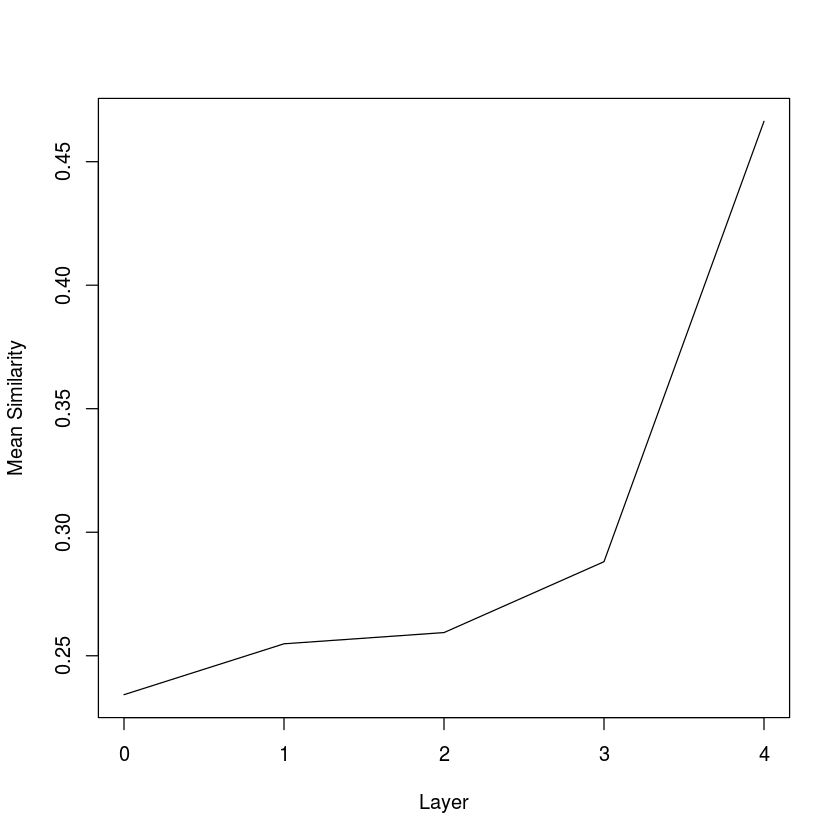

In [10]:
plot(colnames, layerMeanSimilarities, xlab="Layer", ylab="Mean Similarity", type = "l")

In [11]:
mapSimilarity <- function(mapID) {
    map <- getShortestPath(as.character(mapID))
    if (is.null(map)) return (NaN)
    communities <- sapply(rownames(map), function(rowname) getGenes(rowname))
    communitySimilarities <- mclusterSim(clusters = communities, semData = scGO, measure = "Wang", combine = "BMA")
    return(mean(communitySimilarities[upper.tri(communitySimilarities)]))
}

In [12]:
similarityOfAllMapsOnLayer <- function(layer) {
    mapSimilarities <- sapply(unique(assignments[,layer][assignments[,layer] != -1]), mapSimilarity)
    mapSimilarities <- mapSimilarities[!is.na(mapSimilarities)]
    return(mean(mapSimilarities))
}

In [13]:
layerMeanMapSimilarities <- sapply(colnames[1:length(colnames)-1], similarityOfAllMapsOnLayer)

In [14]:
layerMeanMapSimilarities

0         1         2         3 
0.6245714 0.5493000 0.3965000 0.2673167

In [ ]:
getDistance <- function(c1, c2) {
    
    m1 <- getSuperCommunity(c1)
    m2 <- getSuperCommunity(c2)
    
    if (m1 == m2) return(getShortestPath(m1)[c1, c2])
        
    d1 <- getDepth(c1)
    d2 <- getDepth(c2)
        
    if (d1 == d2) return (2 + getDistance(m1, m2))
        
    if (d1 > d2) return (1 + getDistance(m1, c2))
        
    if (d2 > d1) return (1 + getDistance(c1, m2))
    
}

In [78]:
distances <- sapply(as.character(2:max(assignments)), function(i)
    sapply(as.character(2:max(assignments)), function(j) {
        return(getDistance(i, j))
    }))

[1] "attempting 2 2"
[1] "attempting 2 3"
[1] "attempting 2 4"
[1] "attempting 2 5"
[1] "attempting 2 6"
[1] "attempting 2 7"
[1] "attempting 2 8"
[1] "attempting 2 9"
[1] "attempting 2 10"
[1] "attempting 2 11"
[1] "attempting 2 12"
[1] "attempting 2 13"
[1] "attempting 2 14"
[1] "attempting 2 15"
[1] "attempting 2 16"
[1] "attempting 2 17"
[1] "attempting 2 18"
[1] "attempting 2 19"
[1] "attempting 2 20"
[1] "attempting 2 21"
[1] "attempting 2 22"
[1] "attempting 2 23"
[1] "attempting 2 24"
[1] "attempting 2 25"
[1] "attempting 2 26"
[1] "attempting 2 27"
[1] "attempting 2 28"
[1] "attempting 2 29"
[1] "attempting 2 30"
[1] "attempting 2 31"
[1] "attempting 2 32"
[1] "attempting 2 33"
[1] "attempting 2 34"
[1] "attempting 2 35"
[1] "attempting 2 36"
[1] "attempting 2 37"
[1] "attempting 2 38"
[1] "attempting 2 39"
[1] "attempting 2 40"
[1] "attempting 2 41"
[1] "attempting 2 42"
[1] "attempting 2 43"
[1] "attempting 2 44"
[1] "attempting 2 45"
[1] "attempting 2 46"
[1] "attempting 2 

In [80]:
head(distances)

,2,3,4,5,6,7,8,9,10,11,⋯,49,50,51,52,53,54,55,56,57,58
2,0,1,1,2,2,1,3,2,2,3,⋯,4,3,3,3,3,3,3,5,5,5
3,1,0,1,1,1,1,2,1,1,2,⋯,3,3,3,3,3,3,3,4,4,4
4,1,1,0,1,2,2,2,2,2,3,⋯,4,4,4,4,4,4,4,5,5,5
5,2,1,1,0,1,2,1,2,2,3,⋯,3,4,4,4,4,4,4,4,4,4
6,2,1,2,1,0,2,1,1,2,2,⋯,2,4,4,4,4,4,4,3,3,3
7,1,1,2,2,2,0,3,2,2,3,⋯,4,2,2,2,2,2,2,5,5,5


In [84]:
similarities <- sapply(2:max(assignments), function(i)
    sapply(2:max(assignments), function(j) {
        return(clusterSim(cluster1 = geneCommunities[[i]], 
                          cluster2 = geneCommunities[[j]], semData = scGO, measure = "Wang", combine = "BMA"))
    }))

In [86]:
head(similarities)

1.000,0.336,0.661,0.620,0.617,0.662,0.578,0.551,0.626,0.418,⋯,0.443,0.177,0.528,0.286,0.418,0.319,0.212,0.436,0.270,0.420
0.336,1.000,0.318,0.355,0.314,0.324,0.303,0.323,0.433,0.389,⋯,0.339,0.234,0.276,0.375,0.394,0.296,0.178,0.285,0.252,0.221
0.661,0.318,1.000,0.627,0.675,0.639,0.639,0.485,0.594,0.398,⋯,0.477,0.170,0.508,0.350,0.444,0.303,0.238,0.467,0.242,0.421
0.620,0.355,0.627,1.000,0.626,0.630,0.604,0.452,0.557,0.412,⋯,0.408,0.198,0.501,0.323,0.432,0.350,0.222,0.432,0.238,0.361
0.617,0.314,0.675,0.626,1.000,0.640,0.653,0.499,0.593,0.469,⋯,0.528,0.184,0.493,0.325,0.433,0.318,0.212,0.561,0.358,1.000
0.662,0.324,0.639,0.630,0.640,1.000,0.586,0.424,0.588,0.451,⋯,0.439,0.189,0.597,0.305,0.455,0.359,0.269,0.423,0.265,0.388
